# Importing libraries and loading data

In [13]:
import tensorflow as tf
import tensorflow
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras import initializers
from utils import *

# Process weathertypes, remove empty windspeed and store (ignore if already done)

In [14]:
def update_one_hot_data(combined_path,weather_combined_path):
    if not check_if_the_tsv_hot_file_already_has_processed_columns(weather_combined_path):
        df = pd.read_csv(combined_path,
                         sep='\t',
                         header=0) 
        weather_unique_combinations = df.weather_condition.unique()

        #Get list of all unique weather types
        types = []
        for el in weather_unique_combinations:
            for wc in el.split('.'):
                if(wc != ''):            
                    types.append(wc.strip())
        true_unique =  set(types)

        #Add columns with default value 0 for all unique weather types
        for unique_weather_type in true_unique:
            df[unique_weather_type]=0

        #Loop over all records and set value to 1 for their corresponding weather_types
        for index, row in df.iterrows():
            row_types = []
            for wc in row["weather_condition"].split('.'):
                if(wc != ''):            
                    row_types.append(wc.strip())
            for t in row_types:
                df.at[index,t]=1


        #remove empty windspeeds
        df = df[df.wind_speed.apply(lambda x: str(x).isnumeric())]

        #remove original weather_condition column and store, to avoid rerun
        df =  df.drop(columns="weather_condition")
        df.to_csv(weather_combined_path,
                  sep='\t',
                  index=False,
                  header=True)    
    else:
        print("File already processed.")
        
combined_path = "./data/combined_data.tsv"
weather_combined_path="./data/combined_one_hot_data.tsv"
update_one_hot_data(combined_path,weather_combined_path)

# Load in data with one_hot weather types

In [15]:
weather_combined_path="./data/combined_one_hot_data.tsv"
df = pd.read_csv(weather_combined_path,
                 sep='\t',
                 header=0)

#choose one station to test on
#df=df[df['device_name']=='CB1143']
print(df)

       device_name  latitude  longitude  timestamp_from  timestamp_until  \
0           CEK049  50.82448   4.393893      1544095800       1544096700   
1           CEK049  50.82448   4.393893      1544096700       1544097600   
2           CEK049  50.82448   4.393893      1544097600       1544098500   
3           CEK049  50.82448   4.393893      1544098500       1544099400   
4           CEK049  50.82448   4.393893      1544099400       1544100300   
5           CEK049  50.82448   4.393893      1544445900       1544446800   
6           CEK049  50.82448   4.393893      1544446800       1544447700   
7           CEK049  50.82448   4.393893      1544447700       1544448600   
8           CEK049  50.82448   4.393893      1544448600       1544449500   
9           CEK049  50.82448   4.393893      1544449500       1544450400   
10          CEK049  50.82448   4.393893      1544510700       1544511600   
11          CEK049  50.82448   4.393893      1544511600       1544512500   
12          

# Remove outliers (bike_count)

In [16]:
def remove_outlier(df_in, col_name):
    """Removes all outliers on a specific column from a given dataframe.

    Args:
        df_in (pandas.DataFrame): Iput pandas dataframe containing outliers
        col_name (str): Column name on which to search outliers

    Returns:
        pandas.DataFrame: DataFrame without outliers
    """         
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1  # Interquartile range
    fence_low = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    return df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)] 
start_size=df.shape[0]
df = remove_outlier(df, "bike_count")
print(df.shape)
print("We have removed "+str(start_size-df.shape[0])+" outliers tuples (which is "+str((start_size-df.shape[0])/start_size*100)+" % of total).")

(94342, 47)
We have removed 7119 outliers tuples (which is 7.016489094331813 % of total).


# Correlation of variables


                     latitude  longitude  timestamp_from  timestamp_until  \
latitude                 1.00      -0.49            0.05             0.05   
longitude               -0.49       1.00           -0.02            -0.02   
timestamp_from           0.05      -0.02            1.00             1.00   
timestamp_until          0.05      -0.02            1.00             1.00   
bike_count               0.14      -0.16            0.12             0.12   
bike_avg_speed           0.05       0.05            0.04             0.04   
weather_timestamp        0.05      -0.02            1.00             1.00   
temperature              0.00       0.02            0.66             0.66   
wind_speed              -0.00      -0.01           -0.14            -0.14   
humidity                 0.02      -0.04           -0.33            -0.33   
barometer               -0.01       0.04           -0.19            -0.19   
visibility               0.02      -0.01            0.25             0.25   

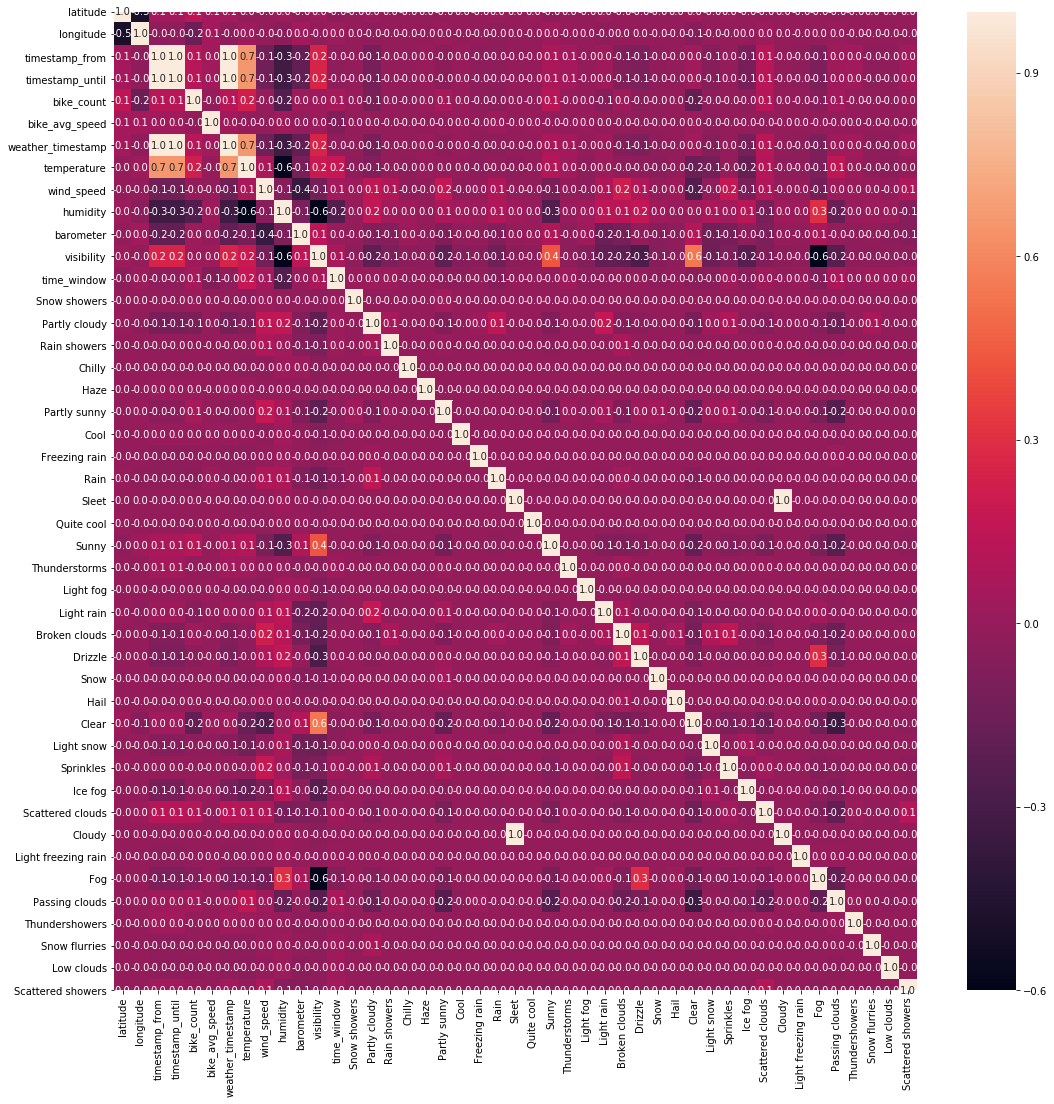

In [17]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(18,18))    

correlation_matrix = df.corr().round(2)
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".001f",ax=ax)

# Feature selection

In [18]:
def remove_features(df):
    return df.drop(columns=[        
    'device_name',
    'timestamp_until',
    'bike_avg_speed',
    'weather_timestamp',
    'wind_direction',
    'wind_speed',
    'barometer',
    'visibility',
    'Ice fog',
    'Thundershowers',
    'Sprinkles',
    'Broken clouds',
    'Rain showers',
    'Snow flurries',
    'Light fog',
    'Sleet',
    'Cloudy',
    'Quite cool'    
])
df=remove_features(df)
print(df.shape)

(94342, 29)


# Build models

In [24]:
def build_normal_model():
    
    initializer = initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)
    model = Sequential()   
    
    model.add(Dense(27, input_dim=27,kernel_initializer='normal', activation='relu'))
    model.add(Dense(14,activation='relu'))    
    model.add(Dense(1, activation='linear'))
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae'])
    model.summary()
    return model
normal_model = build_normal_model()
from sklearn.ensemble import RandomForestRegressor
def build_Random_forest_model():
    model = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
    return model
#normal_model = build_Random_forest_model()
model = normal_model


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 27)                756       
_________________________________________________________________
dense_10 (Dense)             (None, 14)                392       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 15        
Total params: 1,163
Trainable params: 1,163
Non-trainable params: 0
_________________________________________________________________


# Set timestamp as index, set x & y

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
x_train shape (75474, 27)
y_train shape (75474, 1)
Epoch 1/8
75474/75474 [==============================] - 2s 32us/sample - loss: 0.0406 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1502
Epoch 2/8
75474/75474 [==============================] - 2s 31us/sample - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.1370
Epoch 3/8
75474/75474 [==============================] - 2s 31us/sample - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1338
Epoch 4/8
75474/75474 [==============================] - 2s 30us/sample - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1321
Epoch 5/8
75474/75474 [==============================] - 2s 29us/sample - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1305
Epoch 6/8
75474/75474 [==============================] - 2s 30us/sample - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1297
Epoch 7/8


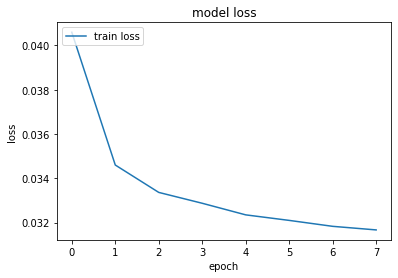

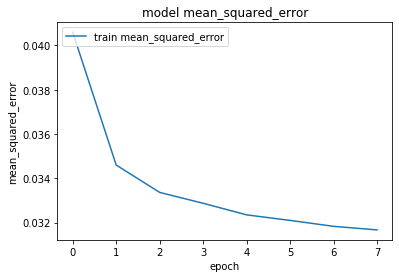

18866/18866 [==============================] - 0s 15us/sample - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1389
[[ 0.0995625 ]
 [ 0.20807947]
 [ 0.20807947]
 ...
 [ 0.09600312]
 [ 0.07414277]
 [-0.00418374]]
MSE: 27.416316787153562
MAE: 3.8895329115747437


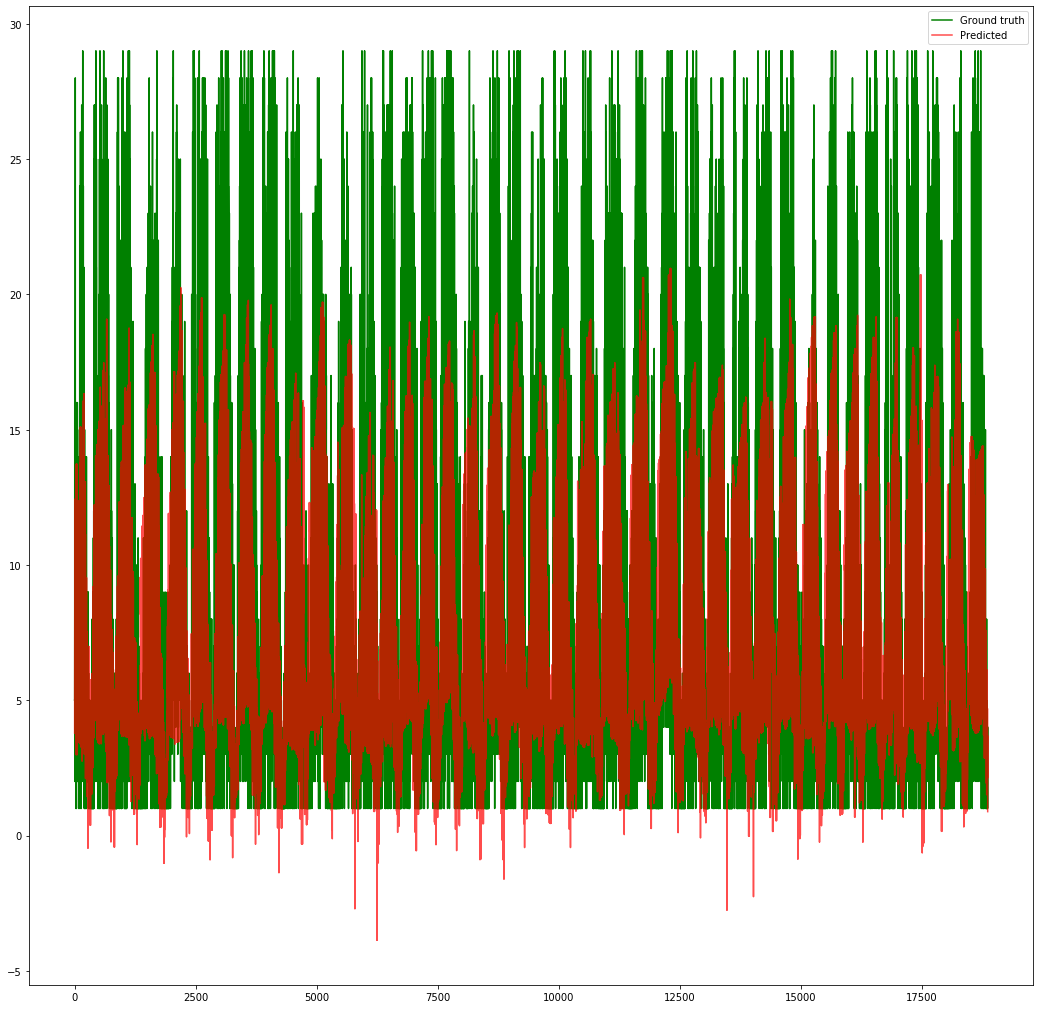

(1451, 47)
We have removed 113 outliers tuples (which is 7.787732598208132 % of total).
(1338, 28)
1338/1338 [==============================] - 0s 14us/sample - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1963
[[0.02760214]
 [0.04331329]
 [0.04459471]
 ...
 [0.500915  ]
 [0.67335296]
 [0.41478032]]
MSE: 78.20769938208376
MAE: 7.065041713294071


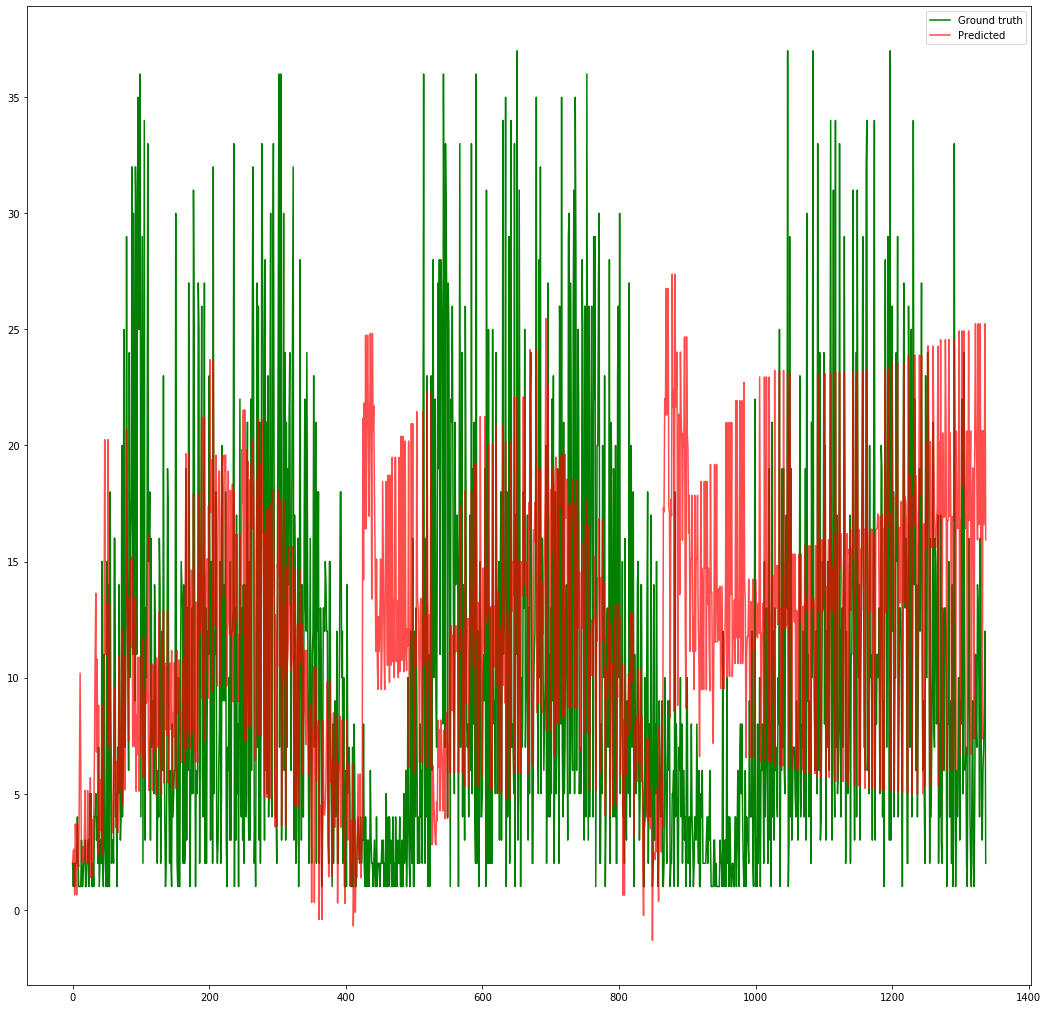

Seq


In [23]:
from sklearn.ensemble import RandomForestRegressor
import sklearn
def execute_Sequential_model(model,df):
    df.set_index('timestamp_from', inplace=True)
    df = df.sort_values(by=['timestamp_from'])

    #set bike_count as Y
    df_y = df.bike_count
    df_x = df.drop(columns="bike_count")
    #Normalization
    x = df_x.values
    y = df_y.values.reshape(-1, 1)

    x_scaler = preprocessing.MinMaxScaler()
    x_normalized = x_scaler.fit_transform(x)

    y_scaler = preprocessing.MinMaxScaler()
    y_normalized = y_scaler.fit_transform(y)

    x_in = pd.DataFrame(x_normalized)
    y_in = pd.DataFrame(y_normalized)


    #Prepare train & test dataset
    test_size = 0.2
    total = x_in.shape[0]
    train_idx = round((1-test_size) * total)



    x_train = x_in[0:train_idx].values
    #x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

    x_test = x_in[train_idx+1:total-1].values
    #x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

    y_train = y_in[0:train_idx].values
    y_test = y_in[train_idx+1:total-1]



    print("x_train shape {}".format(x_train.shape))
    print("y_train shape {}".format(y_train.shape))
    def show_loss_graph(hist,variable):
        plt.plot(history.history[variable])    
        plt.title('model '+variable)
        plt.ylabel(variable)
        plt.xlabel('epoch')
        plt.legend(['train '+variable], loc='upper left')
        plt.show()
    history=model.fit(x_train, y_train,epochs=8)

    model.save('./model/model-23-jun.bin')
    show_loss_graph(history,"loss")
    show_loss_graph(history,"mean_squared_error")
    def evaluate_model_and_show_graph(x_test,y_test,model):
        model.evaluate(x_test, y_test)

        #x_test = x_train
        #y_test = y_train

        #x_test = x_test[14500:]
        #print(x_test)
        #y_test = y_test[14500:]


        y_prediction = model.predict(x_test)
        print(y_prediction)

        y_pred_scaled = y_scaler.inverse_transform(y_prediction)



        y_test_scaled = y_scaler.inverse_transform(y_test)
        mse = mean_squared_error(y_pred_scaled, y_test_scaled)
        mae=mean_absolute_error(y_pred_scaled, y_test_scaled)
        print("MSE: "+str(mse))
        print("MAE: "+str(mae))

        plt.rcParams['figure.figsize'] = [18, 18]
        l1, = plt.plot(y_test_scaled, 'g')
        l2, = plt.plot(y_pred_scaled, 'r', alpha=0.7)
        plt.legend(['Ground truth', 'Predicted'])
        plt.show()
    evaluate_model_and_show_graph(x_test,y_test,model)
    update_one_hot_data('./data/combined_data_22-jun.tsv','./data/combined_data_22-jun_one_hot_data.tsv')
    df_new_data = pd.read_csv('./data/combined_data_22-jun_one_hot_data.tsv',
                     sep='\t',
                     header=0)
    start_size=df_new_data.shape[0]
    print(df_new_data.shape)
    df_new_data = remove_outlier(df_new_data, "bike_count")
    print("We have removed "+str(start_size-df_new_data.shape[0])+" outliers tuples (which is "+str((start_size-df_new_data.shape[0])/start_size*100)+" % of total).")
    df_new_data=remove_features(df_new_data)    
    df_new_data.set_index('timestamp_from', inplace=True)
    df_new_data = df_new_data.sort_values(by=['timestamp_from'])
    print(df_new_data.shape)


    #set bike_count as Y
    df_y = df_new_data.bike_count
    df_x = df_new_data.drop(columns="bike_count")


    #Normalization
    x = df_x.values
    y = df_y.values.reshape(-1, 1)

    x_scaler = preprocessing.MinMaxScaler()
    x_normalized = x_scaler.fit_transform(x)

    y_scaler = preprocessing.MinMaxScaler()
    y_normalized = y_scaler.fit_transform(y)

    x_in = pd.DataFrame(x_normalized)
    y_in = pd.DataFrame(y_normalized)

    evaluate_model_and_show_graph(x_in,y_in,model)

    return 'Seq'
def execute_Random_forest_model(model):
    return 'Random Forest'
def EXECUTE_MODEL(model,df):
    if isinstance(model,sklearn.ensemble.forest.RandomForestRegressor):
        return execute_Random_forest_model(model,df)
    else:
        return execute_Sequential_model(model,df)
    return 'some'
print(type(model))
print(EXECUTE_MODEL(model,df))



